<a href="https://colab.research.google.com/github/he16946/Data_Labs/blob/master/BankNote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Counterfiet Data

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

## Downloading data

In [0]:
import os
import pandas as pd
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
os.environ['KAGGLE_USERNAME'] = "ce889group3" # username from the json file

os.environ['KAGGLE_KEY'] = "f0ec34f29bf37cceb765b25f5a1bce2c" # key from the json file

! kaggle datasets download -d shantanuss/banknote-authentication-uci

  0% 0.00/19.2k [00:00<?, ?B/s]
100% 19.2k/19.2k [00:00<00:00, 16.9MB/s]


In [0]:
! unzip -q "banknote-authentication-uci.zip"

In [0]:
df = pd.read_csv("BankNoteAuthentication.csv")

In [7]:
df.head

<bound method NDFrame.head of       variance  skewness  curtosis  entropy  class
0      3.62160   8.66610   -2.8073 -0.44699      0
1      4.54590   8.16740   -2.4586 -1.46210      0
2      3.86600  -2.63830    1.9242  0.10645      0
3      3.45660   9.52280   -4.0112 -3.59440      0
4      0.32924  -4.45520    4.5718 -0.98880      0
...        ...       ...       ...      ...    ...
1367   0.40614   1.34920   -1.4501 -0.55949      1
1368  -1.38870  -4.87730    6.4774  0.34179      1
1369  -3.75030 -13.45860   17.5932 -2.77710      1
1370  -3.56370  -8.38270   12.3930 -1.28230      1
1371  -2.54190  -0.65804    2.6842  1.19520      1

[1372 rows x 5 columns]>

In [8]:
print("Total count: ", df['class'].count())

Total count:  1372


In [9]:
print("Counterfiet: ", df['class'].value_counts()[1])
print("Authentic: ", df['class'].value_counts()[0])

Counterfiet:  610
Authentic:  762


In [10]:
print('Counterfiet', round(df['class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Authentic', round(df['class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

Counterfiet 44.46 % of the dataset
Authentic 55.54 % of the dataset


## Creating imbalance

In [0]:
counterfiet = df.loc[df['class'] == 1]
authentic = df.loc[df['class'] == 0]

In [0]:
newcounterfiet = counterfiet.sample(n = 260, random_state = 1)

In [0]:
imb = [authentic, newcounterfiet]
imb = pd.concat(imb)

In [14]:
print('Counterfiet', round(imb['class'].value_counts()[1]/len(imb) * 100,2), '% of the dataset')
print('Authentic', round(imb['class'].value_counts()[0]/len(imb) * 100,2), '% of the dataset')

Counterfiet 25.44 % of the dataset
Authentic 74.56 % of the dataset


## Preprocessing

No columns need to be removed

In [15]:
imb.columns

Index(['variance', 'skewness', 'curtosis', 'entropy', 'class'], dtype='object')

In [16]:
norm = ((imb - imb.min())/(imb.max()-imb.min()))
norm.head()

,variance,skewness,curtosis,entropy,class
0,0.768909,0.839643,0.106783,0.736628,0.0
1,0.835591,0.820982,0.121804,0.644326,0.0
2,0.786541,0.416648,0.310608,0.786951,0.0
3,0.757005,0.871699,0.054921,0.450440,0.0
4,0.531385,0.348662,0.424662,0.687362,0.0


## Cross-validation

In [17]:
features = list(norm.columns[0:4])
print(features)

['variance', 'skewness', 'curtosis', 'entropy']


In [0]:
x = norm[features]
y = norm['class']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [31]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(x_train, y_train)
dummy.score(x_test, y_test)  

0.46484375

In [33]:
dt = DecisionTreeClassifier(min_samples_split = 30, max_depth = 4, random_state = 32)
dt.fit(x_train, y_train)
print("DT score: ", dt.score(x_test, y_test))
print("Train score: ", cross_validate(dt, x_train, y_train)['test_score'].mean())
print("Test score: ", cross_validate(dt, x_test, y_test)['test_score'].mean())

DT score:  0.96484375
Train score:  0.9517018928783635
Test score:  0.9220211161387633


In [34]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 32)
rf.fit(x_train, y_train)
print("DT score: ", rf.score(x_test, y_test))
print("Train score: ", cross_validate(rf, x_train, y_train)['test_score'].mean())
print("Test score: ", cross_validate(rf, x_test, y_test)['test_score'].mean())

DT score:  0.953125
Train score:  0.9504201680672268
Test score:  0.9686274509803923


Feature ranking:
1. variance (0.635334)
2. skewness (0.230231)
3. curtosis (0.134435)
4. entropy (0.000000)


(0.0, 0.6671011713817672)

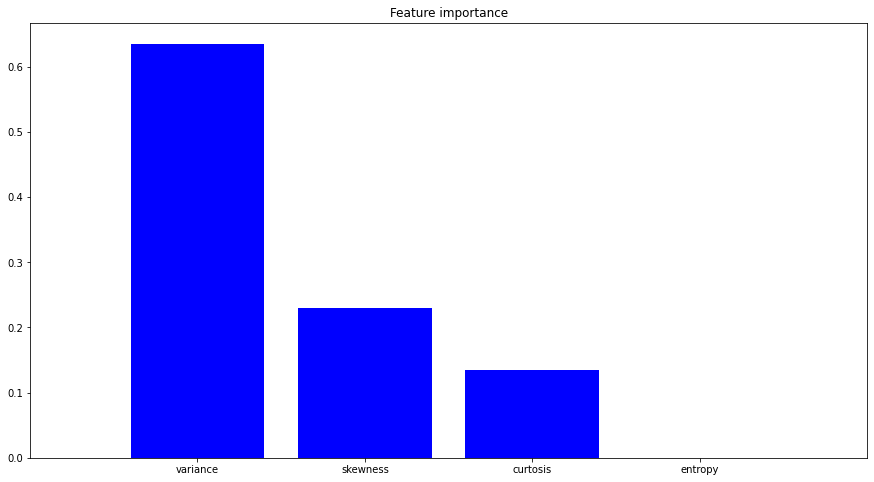

In [35]:
dt.fit(x, y)
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

fig = plt.figure()
plt.title("Feature importance")
plt.bar(range(x.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])

Feature ranking:
1. variance (0.532800)
2. skewness (0.266916)
3. curtosis (0.142481)
4. entropy (0.057803)


(0.0, 0.5594394765951045)

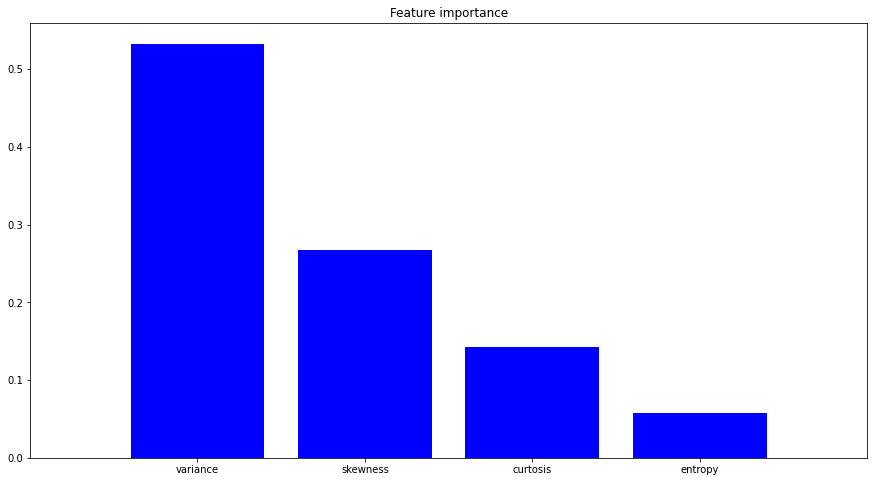

In [36]:
rf.fit(x, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

fig = plt.figure()
plt.title("Feature importance")
plt.bar(range(x.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])